### 1. Data Preparation

Load the required packages -

In [1]:
# Disbaling 'jedi' to resolve the issue of auto completion
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import matplotlib as mpl
import matplotlib.cm as cm
import datetime, nltk
import itertools
import warnings

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, feature_selection, model_selection, metrics
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import linear_model, neighbors, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected = True)
warnings.filterwarnings('ignore')
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

#### Loading the Data

In [4]:
df_initial = pd.read_excel("D:/Study/Data Science/IIMB_BDA Course/Assignment 3/Q4_Clustering/Online Retail.xlsx",
                            encoding = "ISO-8859-1",
                            dtype = {"CustomerID": str, "InvoiceNo": str})
print('DateFrame Dimensions:', df_initial.shape)

DateFrame Dimensions: (541909, 8)


In [5]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [7]:
# Info of column and null values
def data_info(df):
    tab_info = pd.DataFrame(df.dtypes).T.rename(index = {0:'column type'})
    tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                          rename(index = {0:'null values (%)'}))
    display(tab_info)
    return

In [8]:
data_info(df_initial)
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


`25% customer id's are blank and it is not able to impute the data using any of the other available variable -` 

In [9]:
df_initial.dropna(subset=['CustomerID'], inplace=True)
print('DateFrame Dimensions:', df_initial.shape)

#-------
data_info(df_initial)

DateFrame Dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [10]:
print('Duplicate Entries:{}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace=True)
#-------
print('Duplicate Entries:{}'.format(df_initial.duplicated().sum()))

Duplicate Entries:5225
Duplicate Entries:0


In [11]:
df_initial.shape

(401604, 8)

### Exploring the contain of the variables

In [12]:
%%html
<style>
table {float:left}
</style>

| Variable Name | Description |         
| :-:           |:-------------: | 
|InvoiceNo| Invoice number |
| StockCode | Product (item) code |
|Description| Product (item) name |
|Quantity| The quantities of each product (item) per transaction |
|InvoiceDate| Invoice Date and time |
|UnitPrice| Unit price |
|CustomerID| Customer number |
|Country| Country name  |

In [13]:
tmp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
tmp = tmp.reset_index(drop =False)
countries = tmp['Country'].value_counts()
print('No. of countries in the dataframe:{}'.format(len(countries)))

No. of countries in the dataframe:37


In [14]:
tmp

,CustomerID,InvoiceNo,Country
0,12346,541431,United Kingdom
1,12346,C541433,United Kingdom
2,12347,537626,Iceland
3,12347,542237,Iceland
4,12347,549222,Iceland
5,12347,556201,Iceland
6,12347,562032,Iceland
7,12347,573511,Iceland
8,12347,581180,Iceland
9,12348,539318,Finland


#### chloropleth map

In [15]:
countries

United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Malta                      10
Singapore                  10
Unspecified                 8
Iceland                     7
USA                         7
Israel                      6
Greece                      6
Canada                      6
European Community          5
Czech Republic              5
Lithuania                   4
United Arab Emirates        3
Bahrain                     2
Saudi Arab

In [16]:
data = dict(type = 'choropleth',
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title': 'Order No.'},
            colorscale=[[0, 'rgb(224,255,255)'],
                        [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
                        [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
                        [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
                        [1, 'rgb(227,26,28)']],
            reversescale = False)
#--------
layout = dict(title = 'Number of orders per country <br> (Hover for the breakdown)',
              geo = dict(showframe = True, projection = {'type':'mercator'}))
#--------
choromap = go.Figure(data = [data], layout=layout)
iplot(choromap, validate=False)

#### Check out the number of Products & Customers

In [17]:
pd.DataFrame([{ 'products':    len(df_initial['StockCode'].value_counts()),
                'transactions':len(df_initial['InvoiceNo'].value_counts()), 
                'customers':   len(df_initial['CustomerID'].value_counts()),
               }], columns = ['products', 'transactions', 'customers'],
              index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


#### Number of products in every transaction

In [18]:
tmp = df_initial.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
no_products_per_basket = tmp.rename(columns = {'InvoiceDate': 'Number of Products'})
no_products_per_basket[0:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of Products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The above data shows - 
1. Infreqenct customers (eg. - 12346)
2. Cancelled invoice have 'c' prefix
3. Customer with bulk purchase

#### Cancelled transactions

In [19]:
no_products_per_basket['order_cancelled'] = no_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
#display(no_products_per_basket[:10])
no_products_per_basket.sample(10)
#------------------
n1 = no_products_per_basket.order_cancelled.sum()
n2 = no_products_per_basket.shape[0]
print('Number of product cancelled: {}/{} ({:0.2f}%)'.format(n1, n2, n1/n2*100))

Number of product cancelled: 3654/22190 (16.47%)


`Number is cancellation is around 16%, which is quite high in numbers.`

In [20]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


As per the above data, cancelled transaction is having a negative value of qunatity. Let's check if this is TRUE for all the entries. Also check what is the corresponding entry of cancelled transaction. To do this, I decide to locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice):

In [21]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]

#------------
for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID']  == col [0] )  & 
                  (df_initial['Quantity']    == -col[1] ) &
                  (df_initial['Description'] == col [3] )
                 ].shape[0] == 0:
        print(df_check.loc[index])
        print(15*'-'+'>'+ 'Hypothesis Not Fulfilled')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
--------------->Hypothesis Not Fulfilled


`Try to perform the test without 'Description' = 'Discount'`

In [22]:
df_check = df_initial[ (df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount') 
                     ][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]

#------------
for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID']  == col [0] )  & 
                  (df_initial['Quantity']    == -col[1] ) &
                  (df_initial['Description'] == col [3] )
                 ].shape[0] == 0:
        print(df_check.loc[index])
        print(15*'-'+'>'+ 'Hypothesis Not Fulfilled')
        break

CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
--------------->Hypothesis Not Fulfilled


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

Let's create a new variable to check the cancellation entries with & without counterpart -

In [24]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [25]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


Remove the above entries from the dataset

In [26]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,0
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,0


In [27]:
df_cleaned.drop(entry_to_remove, axis = 0 , inplace=True)
df_cleaned.drop(doubtfull_entry, axis = 0 , inplace=True)

remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]

print('No. of entries to delete:{}'.format(remaining_entries.shape[0]))
remaining_entries[0:5]

No. of entries to delete:48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [28]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


#### Stock Code

Check the stock codes with the specific letters

In [29]:
list_spl_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True, na = False)
                           ]['StockCode'].unique()
list_spl_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [30]:
for code in list_spl_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


#### Basket Price

In [31]:
df_cleaned.sample(40)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
279194,561246,21172,PARTY METAL SIGN,12,2011-07-26 11:38:00,1.45,16951,United Kingdom,0
245636,558621,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-06-30 16:43:00,1.25,13745,United Kingdom,0
403302,571559,23306,SET OF 36 DOILIES PANTRY DESIGN,12,2011-10-18 09:32:00,1.45,14911,EIRE,0
352756,567683,22469,HEART OF WICKER SMALL,12,2011-09-21 16:31:00,1.65,13704,United Kingdom,0
480346,577297,22155,STAR DECORATION RUSTIC,2,2011-11-18 12:48:00,0.42,14593,United Kingdom,0
473056,576779,21914,BLUE HARMONICA IN BOX,1,2011-11-16 13:25:00,1.25,14554,United Kingdom,0
504947,578998,22309,TEA COSY RED STRIPE,2,2011-11-27 16:05:00,2.55,15436,United Kingdom,0
248374,558812,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,24,2011-07-04 11:35:00,0.85,16265,United Kingdom,0
233572,557476,23202,JUMBO BAG VINTAGE LEAF,10,2011-06-20 13:41:00,2.08,18223,United Kingdom,0
150238,549372,35921,EASTER BUNNY HANGING GARLAND,5,2011-04-08 11:28:00,1.25,14958,United Kingdom,0


In [32]:
df_cleaned['Total_Price'] = df_cleaned['UnitPrice']*(df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Total_Price
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


`Identify the total order price`

In [33]:
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['Total_Price'].sum()
basket_price = temp.rename(columns = {'Total_Price': 'Basket Price'})

#-------------
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:,'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

#------------------
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


#### Purchase as per total prize

In [34]:
# Purchase count
price_range = [0,50,100,200,500,1000,5000,50000]
count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    
    count_price.append(val)

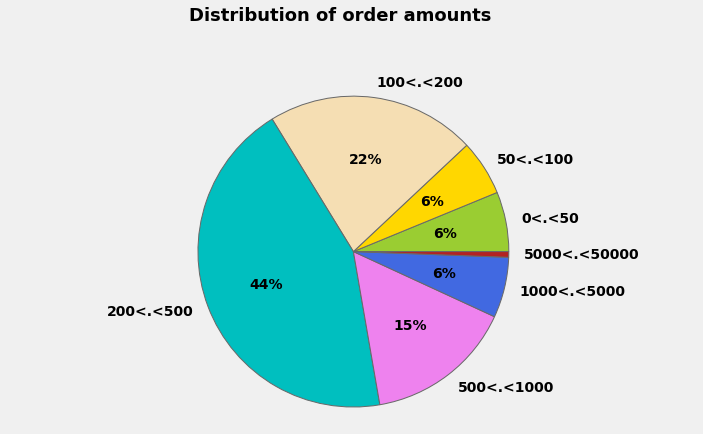

In [35]:
#--------------------------------
# Representation of the number of purchases / amount
plt.rc('font', weight = 'bold')
f, ax = plt.subplots(figsize = (11,6))
colors = ['yellowgreen', 'gold', 'wheat', 'c','violet','royalblue', 'firebrick']
labels = ['{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]

sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors, 
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18);

It can be seen that vast majority of purchase made is > 200 pounds.

In [36]:
count_price

[1142, 1063, 4001, 8084, 2830, 1157, 108]

#### Product Description: Small piece of text analytics

In [37]:
is_noun = lambda pos:pos[:2] == 'NN'

def keyword_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()   # Collect the word/root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
        
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
            
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("No. of Keywords in variable '{}':{}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [38]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

The execution of this function returns three variables:

- keywords: the list of extracted keywords
- keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- count_keywords: dictionary listing the number of times every word is used

At this point, I convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [39]:
df_products

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
5,SET 7 BABUSHKA NESTING BOXES
6,GLASS STAR FROSTED T-LIGHT HOLDER
7,HAND WARMER UNION JACK
8,HAND WARMER RED POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT


In [40]:
keywords, keywords_roots, keywords_select, count_keywords = keyword_inventory(df_products)

No. of Keywords in variable 'Description':1484


In [41]:
#type(count_keywords)
count_keywords

{'heart': 267,
 'holder': 120,
 'metal': 99,
 'lantern': 8,
 'cream': 49,
 'cupid': 2,
 'coat': 7,
 'hanger': 19,
 'union': 28,
 'flag': 12,
 'water': 36,
 'bottl': 44,
 'nest': 3,
 'box': 155,
 'glass': 149,
 'star': 59,
 'hand': 20,
 'jack': 21,
 'warmer': 17,
 'dot': 3,
 'bird': 45,
 'ornament': 1,
 'poppi': 7,
 'playhous': 4,
 'bedroom': 1,
 'kitchen': 20,
 'feltcraft': 24,
 'princess': 3,
 'charlott': 11,
 'doll': 11,
 'ivori': 54,
 'cosi': 6,
 'colour': 26,
 'teaspoon': 1,
 'vintag': 211,
 'jigsaw': 15,
 'block': 9,
 'alphabet': 13,
 'home': 49,
 'build': 3,
 'word': 3,
 'love': 9,
 'recip': 6,
 'england': 4,
 'jam': 18,
 'jar': 39,
 'rack': 15,
 'pari': 5,
 'fashion': 3,
 'bath': 8,
 'alarm': 7,
 'clock': 44,
 'bakelik': 4,
 'pink': 189,
 'green': 14,
 'panda': 1,
 'bunni': 25,
 'sheet': 8,
 'tape': 18,
 'globe': 1,
 'head': 3,
 'tail': 4,
 'game': 6,
 'set/2': 1,
 'retrospot': 90,
 'tea': 55,
 'towel': 22,
 'round': 30,
 'snack': 9,
 'woodland': 21,
 'spaceboy': 29,
 'lunch': 2

#### Converting `count_keywords` dict to list

In [42]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k], v])

list_products.sort(key = lambda x:x[1], reverse = True)

In [43]:
list_products

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['pink', 189],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120],
 ['flower', 120],
 ['decorative', 109],
 ['metal', 99],
 ['retrospot', 90],
 ['card', 90],
 ['necklac', 85],
 ['paper', 84],
 ['blue', 80],
 ['art', 75],
 ['silver', 72],
 ['cake', 70],
 ['polkadot', 68],
 ['cover', 68],
 ['mug', 66],
 ['tin', 66],
 ['wrap', 65],
 ['sign', 64],
 ['pack', 61],
 ['egg', 61],
 ['bracelet', 61],
 ['star', 59],
 ['bowl', 57],
 ['mini', 56],
 ['tea', 55],
 ['garden', 55],
 ['wall', 55],
 ['ivory', 54],
 ['cushion', 54],
 ['frame', 52],
 ['mirror', 50],
 ['cream', 49],
 ['home', 49],
 ['gift', 49],
 ['earrings', 49],
 ['ring', 46],
 ['bird', 45],
 ['bottle', 44],
 ['clock', 44],
 ['paisley', 42],
 ['letter', 42],
 ['party', 42],
 ['charm', 41],
 ['wood', 40],
 ['ribbon', 40],
 ['jar', 39],
 ['garland', 39],
 ['hook', 39],
 ['gold', 39],
 ['easter', 39],
 ['bead', 38],
 ['dr

#### Representation of most common keywords

In [44]:
liste = sorted(list_products, key = lambda x:x[1], reverse=True)

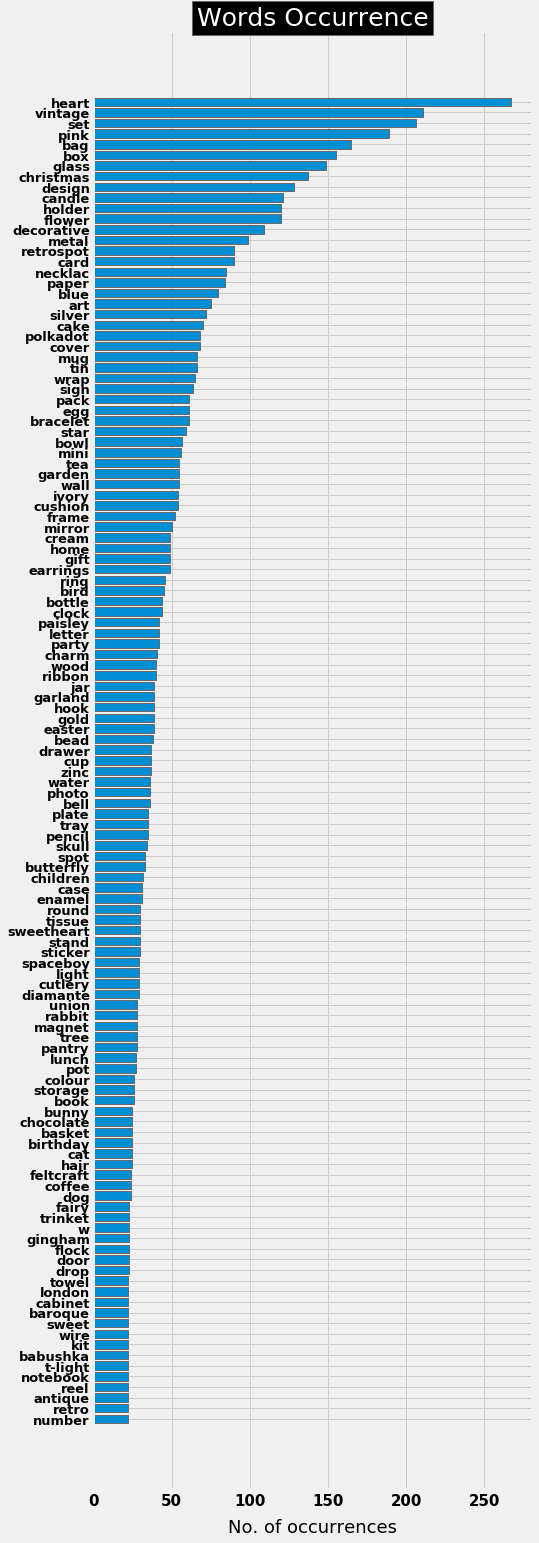

In [45]:
plt.rc('font', weight = 'bold')
fig, ax = plt.subplots(figsize = (7,25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurrences", fontsize = 18, labelpad=10)
ax.barh(x_axis, y_axis, align="center")
ax = plt.gca()
ax.invert_yaxis()
#-------------------
plt.title("Words Occurrence", bbox = {'facecolor':'k', 'pad':5}, color = 'w', fontsize = 25)
plt.show()

just taking the words with more than 13 count and removing some meaning less words.

In [46]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if('+' in word) or ('/' in word): continue
    
    list_products.append([word, v])
#-------------
list_products.sort(key = lambda x:x[1], reverse =True)
print('Preserved Words:', len(list_products))

Preserved Words: 193


#### Data Encoding

In [47]:
liste_products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurrence in list_products:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), liste_products))

In [48]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding the price range columns to the matrix for more balanced group 

In [49]:
threshold = [0,1,2,3,5,10]
label_col = []

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    
    label_col.append(col)
    X.loc[:,col] = 0
    
for i, prod in enumerate(liste_products):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j += 1
        if j == len(threshold): break
    
    X.loc[i, label_col[j-1]] = 1

In [50]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [51]:
print('{:<8} {:<20} \n'.format('range', 'No. of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    
    print('{:<10} {:<20}'.format(col, X.loc[:, col].sum()))    

range    No. of products      
--------------------
0<.<1      964                 
1<.<2      1009                
2<.<3      673                 
3<.<5      606                 
5<.<10     470                 
.>10       156                 


In [52]:
964+1009+673+606+470+156


3878

#### Creating clusters of products

- The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [53]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init = "k-means++", n_clusters = n_clusters, n_init=30 )
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print('For n_clusters =', n_clusters, "The average silhouette score is:", silhouette_avg)

For n_clusters = 3 The average silhouette score is: 0.10071681758064248
For n_clusters = 4 The average silhouette score is: 0.12208239761153944
For n_clusters = 5 The average silhouette score is: 0.1466257603527048
For n_clusters = 6 The average silhouette score is: 0.14524437780972266
For n_clusters = 7 The average silhouette score is: 0.14840750740212266
For n_clusters = 8 The average silhouette score is: 0.14020806474036554
For n_clusters = 9 The average silhouette score is: 0.13193368026637814


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  0.1±0.05  will be obtained for all clusters with n_clusters  >  3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:


In [54]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init = "k-means++", n_clusters = n_clusters, n_init=30 )
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print('For n_clusters =', n_clusters, "The average silhouette score is:", silhouette_avg)

For n_clusters = 5 The average silhouette score is: 0.1454649521746832


#### Characterizing the content of clusters

Check the number of elements in each clusters

In [55]:
pd.Series(clusters).value_counts()

2    1114
1    1009
4     673
3     606
0     476
dtype: int64

**a. Silhouette intra-cluster score**

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the sklearn documentation:

In [56]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

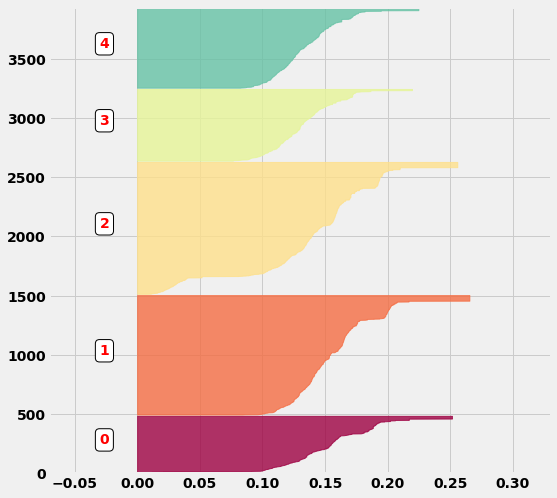

In [57]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

**b. Word Cloud**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [58]:
liste = pd.DataFrame(liste_products)
liste_words = [word for (word, occurrence) in list_products]

occurrence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurrence[i][word] = sum(liste_cluster.loc[:,0].str.contains(word.upper()))    

occurrence

Word cloud -

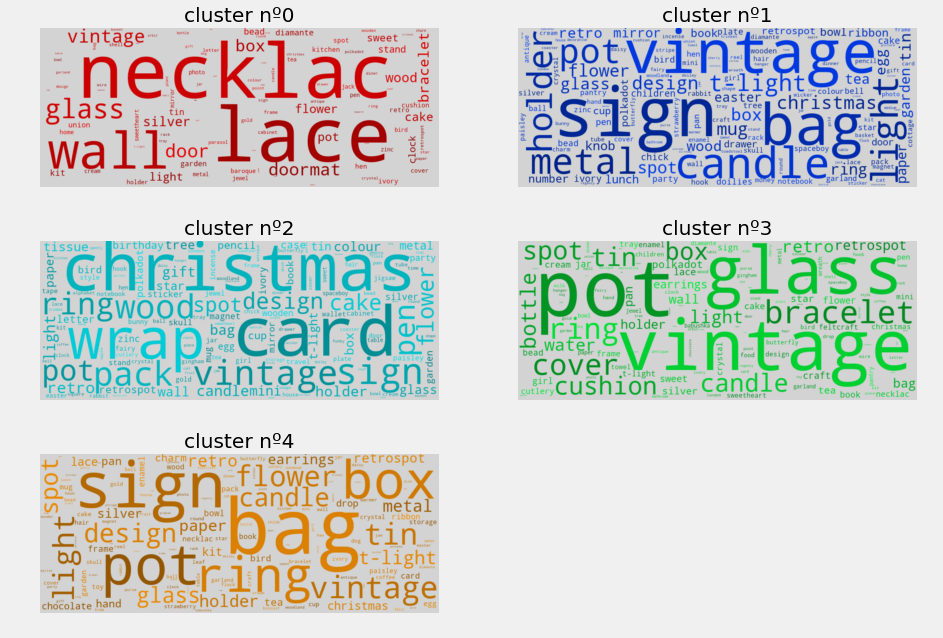

In [59]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurrence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1) 

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

**c. Principal Component Analysis**

Checkout the composition of cluster using PCA

In [60]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

In [61]:
pca_samples

array([[ 4.04146662e-02,  4.97230972e-01,  8.86108601e-02, ...,
         3.53393613e-04, -2.11123394e-03,  1.93919714e-16],
       [-1.82800408e-02,  4.22521729e-01,  5.60009834e-01, ...,
         3.28279183e-04, -1.73540170e-03,  5.51418364e-17],
       [ 1.56363862e-02,  3.15742200e-01,  1.24744354e+00, ...,
        -2.89423998e-03,  2.12892191e-03, -2.22413920e-16],
       ...,
       [-7.00204037e-01, -4.33656636e-01, -1.21753185e-01, ...,
         1.23958283e-03,  7.00072063e-03, -3.05680647e-16],
       [ 4.64950132e-02,  5.08854136e-01,  1.11871933e-01, ...,
         4.64582303e-03,  4.59710854e-05, -1.39147193e-16],
       [-3.63126969e-02,  6.33805390e-01, -6.04740504e-01, ...,
         9.91835682e-05, -9.88603744e-04,  2.73862608e-17]])

and then check for the amount of variance explained by each component:

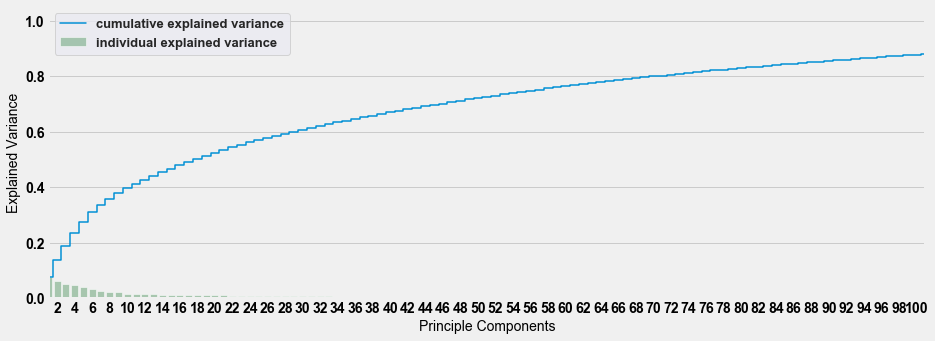

In [62]:
fig, ax = plt.subplots(figsize = (14,5))
sns.set(font_scale = 1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', 
         label = 'cumulative explained variance')
sns.barplot(np.arange(1, matrix.shape[1]+1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
           label = 'individual explained variance')
plt.xlim(0,100)

ax.set_xticklabels([s if int (s.get_text()) % 2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained Variance', fontsize = 14)
plt.xlabel('Principle Components', fontsize = 14)
plt.legend(loc = "upper left", fontsize = 13)

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [63]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

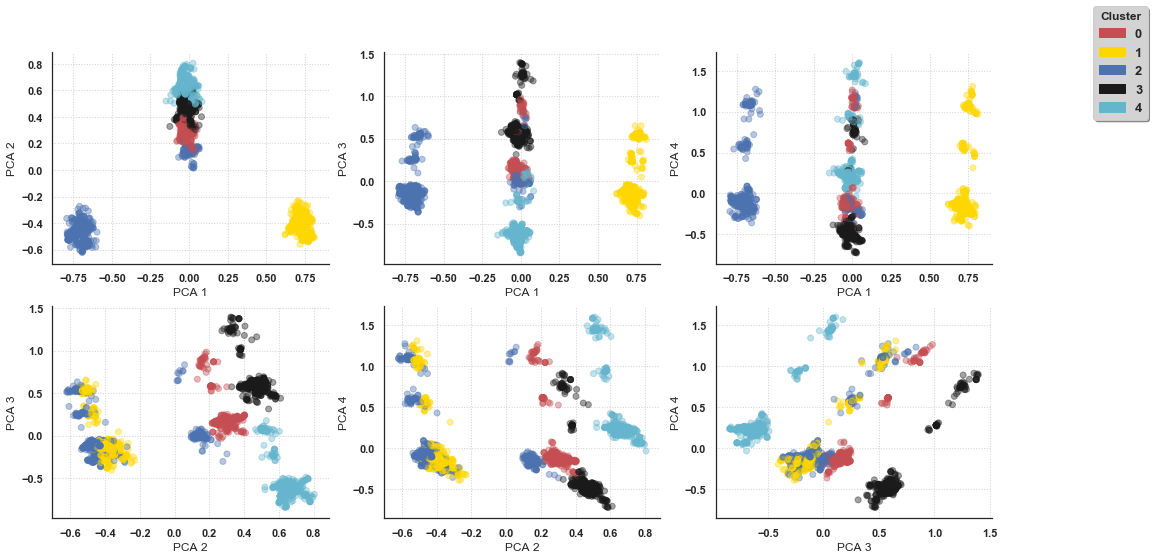

In [64]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()


In [65]:
pca.fit_transform?

In [66]:
mat

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
0,0.040415,0.497232,0.088612,1.585314,-0.341040,-0.165406,0.681985,1.027660,0.750703,0.222244,...,0.015958,-0.096718,0.023071,-0.126810,-0.050139,-0.060642,-0.055321,0.009395,0.020031,4
1,-0.018280,0.422522,0.560009,-0.433863,-0.344757,-0.180221,-0.252113,-0.004569,0.149702,-0.088497,...,0.003394,-0.027014,-0.018413,-0.012722,-0.030423,0.006289,-0.033989,0.044913,-0.040707,3
2,0.015638,0.315747,1.247457,0.749126,-0.505786,-0.012004,-0.163588,-0.125370,-0.027213,-0.015310,...,-0.113167,-0.075361,0.298901,-0.248853,-0.184396,-0.417028,-0.091257,0.044576,-0.073561,3
3,-0.035555,0.467761,0.633847,-0.475269,-0.348035,-0.157558,-0.188841,0.065707,-0.049712,-0.042205,...,-0.268620,-0.394614,0.170014,-0.076490,0.925421,0.297681,-0.322192,-0.094311,0.378539,3
4,0.008751,0.319167,1.232738,0.739151,-0.492980,-0.010319,-0.144179,-0.115465,-0.008469,0.004328,...,-0.026603,-0.105649,-0.001879,-0.010149,-0.014651,-0.080456,-0.015293,-0.030607,-0.074599,3
5,0.036308,0.349954,0.105515,-0.223924,0.774760,0.065538,0.829751,-0.659985,0.034681,0.026827,...,-0.041129,-0.037223,-0.012897,0.030871,0.035953,-0.063710,-0.010871,0.026025,0.048243,0
6,-0.008877,0.450680,0.647797,-0.317088,-0.373513,-0.371304,0.654665,1.433315,0.938304,0.221946,...,-0.046683,0.101581,-0.203413,0.465603,0.117250,-0.133219,-0.040008,-0.008078,-0.026227,3
7,-0.023602,0.652917,-0.594081,0.248370,-0.096736,-0.130988,-0.098931,0.082665,-0.120841,-0.022759,...,0.097606,-0.141408,0.011471,0.010090,0.202027,-0.160640,-0.051469,-0.010352,0.136816,4
8,0.706158,-0.382629,-0.132403,-0.118796,-0.013930,-0.051373,-0.128627,0.096251,-0.067593,-0.064998,...,0.107888,-0.049622,0.000709,0.022013,0.054139,-0.140048,0.058889,0.105206,0.031044,1
9,0.685622,-0.413307,-0.125585,-0.142454,0.003126,-0.077150,-0.033030,0.098425,-0.066200,-0.122329,...,-0.065244,0.144221,-0.280157,-0.005833,0.047328,0.016567,0.281703,-0.272057,0.022544,1


#### Customer Categories

In [67]:
corresp = dict()
for key, value in zip(liste_products, clusters):
    corresp[key] = value
#-----------------
df_cleaned['categ_product'] = df_cleaned.loc[:,'Description'].map(corresp)

In [68]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Total_Price,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,3


**Grouping Products**

In [69]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice']*(df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [70]:
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['Total_Price'].sum()
basket_price = temp.rename(columns={'Total_Price': 'Basket_Price'})
#---------------------------------
# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp
    
#--------------------------------------
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis =1, inplace = True)
basket_price.loc[:,'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

#---------------------
# selection of significant entries:
basket_price = basket_price[basket_price['Basket_Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket_Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,124.44,187.2,23.40,293.35,83.40,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,0.00,130.5,122.59,169.20,53.10,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,0.00,330.9,119.25,115.00,71.10,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,19.90,74.4,41.40,168.76,78.06,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,97.80,109.7,99.55,158.16,119.70,2011-08-02 08:48:00.000000000


**Seperation of Data over time**

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [71]:
print(basket_price['InvoiceDate'].min(), '->', basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [72]:
set_entrainment = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainment.copy(deep = True)

**Customer Order Combinations**

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [73]:
# no. of visits and stats on the amount of the cart / user
transaction_per_user = basket_price.groupby(by=['CustomerID'])['Basket_Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transaction_per_user.loc[:,col] =  basket_price.groupby(by=['CustomerID'])[col].sum()/transaction_per_user['sum']*100

transaction_per_user.reset_index(drop=False, inplace=True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transaction_per_user.sort_values('CustomerID' ,ascending=True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,8.676179,29.836681,14.554295,32.408290,14.524555
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,41.953217,58.046783,0.000000,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,48.444976,23.654306,0.000000,27.900718
3,12352,6,144.35,840.30,345.663333,2073.98,14.301006,12.892120,53.725205,15.711338,3.370331
4,12353,1,89.00,89.00,89.000000,89.00,22.359551,13.033708,44.719101,0.000000,19.887640


Finally, I define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [74]:
last_date = basket_price['InvoiceDate'].max().date()

In [75]:
first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x: (last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transaction_per_user.loc[:,'LastPurchase'] = test2.reset_index(drop=False)['InvoiceDate']
transaction_per_user.loc[:,'FirstPurchase'] = test.reset_index(drop=False)['InvoiceDate']
transaction_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,8.676179,29.836681,14.554295,32.408290,14.524555,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,41.953217,58.046783,0.000000,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,48.444976,23.654306,0.000000,27.900718,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,14.301006,12.892120,53.725205,15.711338,3.370331,2,226
4,12353,1,89.00,89.00,89.000000,89.00,22.359551,13.033708,44.719101,0.000000,19.887640,134,134


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [76]:
n1 = transaction_per_user[transaction_per_user['count'] == 1].shape[0]
n2 = transaction_per_user.shape[0]
print('No. of customers with Single Purchase:{:<2}/{:<5} ({:2.2f}%)'.format(n1,n2,n1/n2*100))

No. of customers with Single Purchase:1445/3608  (40.05%)


The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [77]:
transaction_per_user.columns

Index(['CustomerID', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
       'categ_1', 'categ_2', 'categ_3', 'categ_4', 'LastPurchase',
       'FirstPurchase'],
      dtype='object')

In [78]:
list_col = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transaction_per_user.copy(deep=True)
matrix = selected_customers[list_col].as_matrix()

In [79]:
matrix

array([[  5.        , 382.52      , 711.79      , ...,  14.55429509,
         32.40828992,  14.52455516],
       [  4.        , 227.44      , 892.8       , ...,  58.04678284,
          0.        ,   0.        ],
       [  1.        , 334.4       , 334.4       , ...,  23.65430622,
          0.        ,  27.9007177 ],
       ...,
       [  1.        ,  98.76      ,  98.76      , ...,  45.17010936,
         13.66950182,  17.92223572],
       [ 10.        ,   2.5       , 192.8       , ...,  17.75162629,
          8.29016498,  34.90794328],
       [  1.        , 765.28      , 765.28      , ...,   5.31570144,
          1.9600669 ,  17.60140079]])

Standarised the data

In [80]:
scaler = StandardScaler()
scaler.fit(matrix)
print('Variable mean values: \n' + 90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Variable mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  15.6945421
  25.22916919  21.51301063  16.37327913  21.19884856]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [81]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

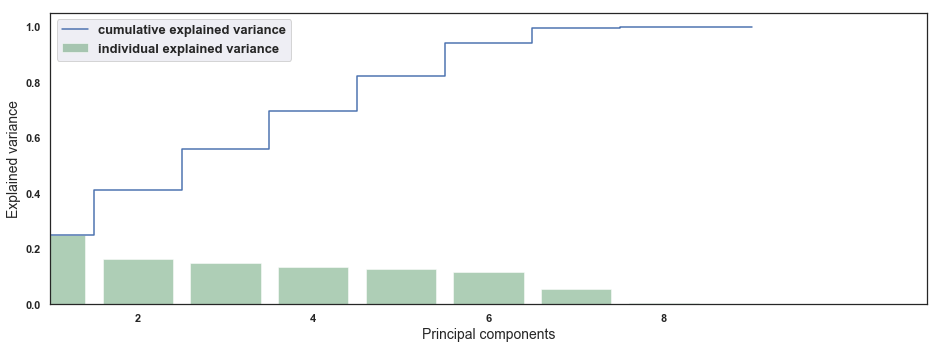

In [82]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

**Creation of customer categories**

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means algorithm` from `scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

In [83]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('Silhouette Score: {:<.3f}'.format(silhouette_avg))

Silhouette Score: 0.214


At first, I look at the number of customers in each cluster:

In [84]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['no. of customers']).T

,7,10,2,0,1,3,4,6,9,5,8
no. of customers,1497,441,368,347,291,288,195,151,12,11,7


There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [85]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

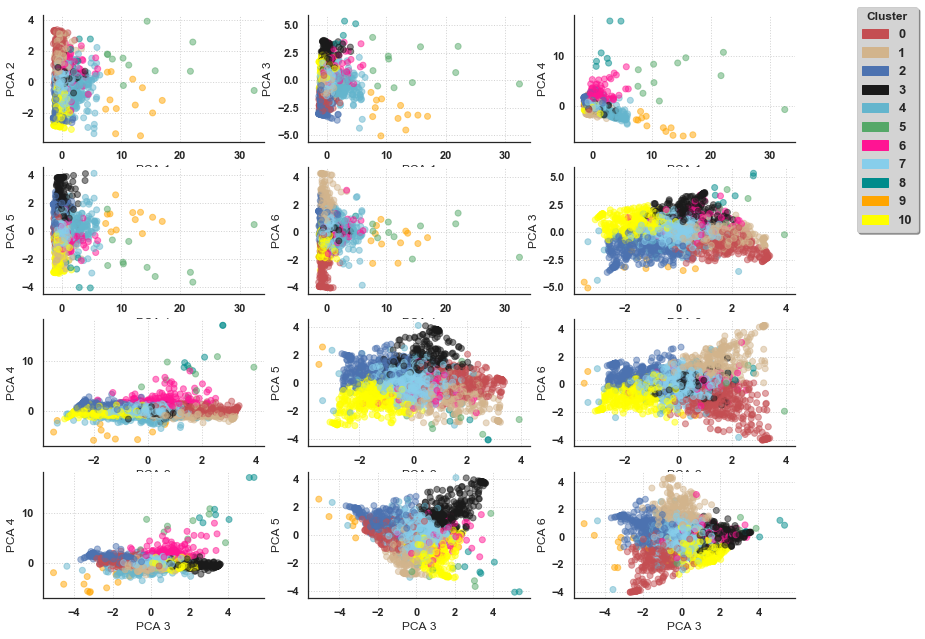

In [86]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

**Intra cluster Silhouette score**

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

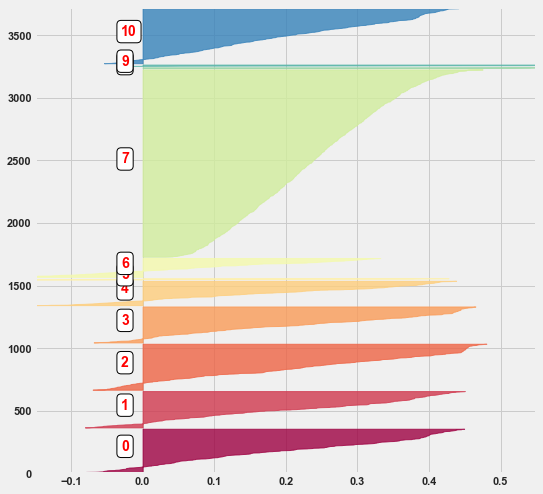

In [87]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**Customers morphotype**

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [88]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable size ):

In [89]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount sent in each product category and then, according to the total amount spent:

In [90]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,0.0,2.478386,193.028963,308.191441,244.378791,621.351354,52.460700,11.317999,11.637819,12.992090,11.607653,347
1,10.0,2.442177,208.693787,319.857032,261.138473,661.122701,5.873525,57.925164,15.546757,7.786417,12.871513,441
2,2.0,2.184783,194.853016,325.513098,250.255837,596.356114,7.520003,14.998310,61.268240,6.958614,9.254833,368
3,1.0,2.182131,201.712509,342.291856,265.644818,675.912784,10.754109,13.823109,9.914231,51.279440,14.282338,291
4,3.0,2.600694,207.362604,371.908750,285.408064,808.504861,7.289649,14.961385,9.486102,7.053134,61.209730,288
5,7.0,3.293253,220.016194,463.607623,332.338792,1100.705051,14.879289,25.562920,20.581778,16.934630,22.045342,1497
6,4.0,1.707692,1026.285128,1359.757338,1180.571736,2114.225082,13.466860,26.568721,21.567523,17.063427,21.333816,195
7,9.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,18.278470,20.102624,33.125675,15.171169,13.322062,12
8,6.0,18.331126,86.844503,1530.301656,553.066872,9682.532583,15.656436,23.912531,18.931468,16.344368,25.175948,151
9,8.0,92.000000,10.985714,1858.250000,374.601553,34845.105714,17.721038,25.832531,20.541454,13.402971,22.527857,7


**Customers morphology**

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts"

In [91]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

This allows to have a global view of the content of each cluster:

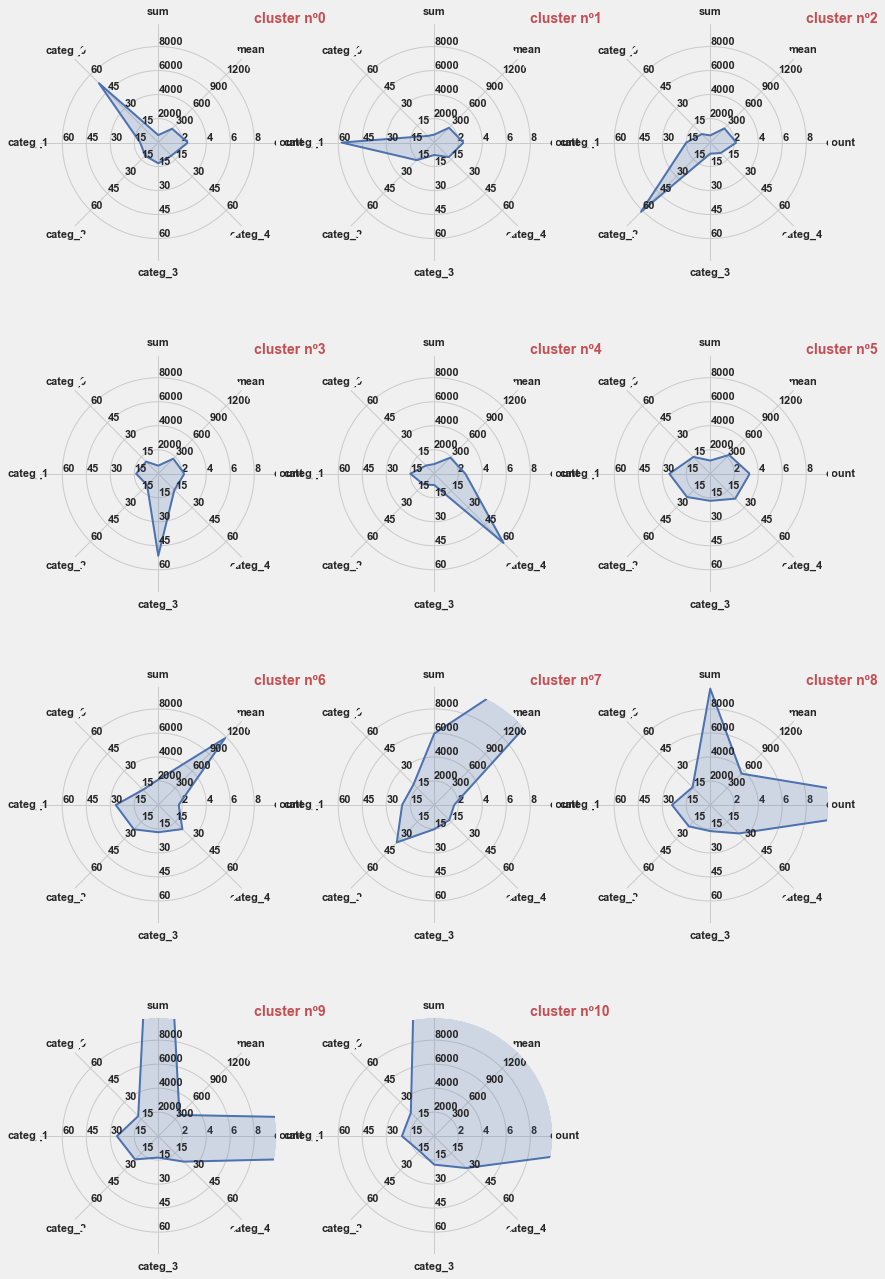

In [92]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1
#plt.tight_layout()

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages ( mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count ).

### Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in scikit-learn. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

All classes have a function called `__init__()`, which is always executed when the class is being initiated. Use the __init__() function to assign values to object properties, or other operations that are necessary to do when the object is being created.

`Objects` are an encapsulation of variables and functions into a single entity. Objects get their variables and functions from classes. `Classes` are essentially a template to create your objects.

The `self` parameter is a reference to the current instance of the class, and is used to access variables that belongs to the class. It does not have to be named self , you can call it whatever you like, but it has to be the first parameter of any function in the class-

In [93]:
class Class_Fit(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)   # Call predict method
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator=self.clf, param_grid=parameters, cv =Kfold)   # Define new variable 'grid'
        
    def grid_fit(self,X,Y):                      # Defining method inside the object (Class_Fit)
        self.grid.fit(X,Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print('Precision:{:.2f}%'.format(100*metrics.accuracy_score(Y, self.predictions)))

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [94]:
basket_price.columns

Index(['CustomerID', 'InvoiceNo', 'Basket_Price', 'categ_0', 'categ_1',
       'categ_2', 'categ_3', 'categ_4', 'InvoiceDate'],
      dtype='object')

In [95]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, I split the dataset in train and test sets:

In [96]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y, train_size = 0.8)

**Support Vector Machine Classifier (SVC)**

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the Class_Fit class and then callgrid_search(). When calling this method, I provide as parameters:

the hyperparameters for which I will seek an optimal value
the number of folds to be used for cross-validation

In [97]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this instance is created, I adjust the classifier to the training data:

In [98]:
svc.grid_fit(X = X_train, Y = Y_train)

then I can test the quality of the prediction with respect to the test data

In [100]:
svc.grid_predict(X_test, Y_test)

Precision:85.73%


#### Confusion Matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them

In [102]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Convert the denominator into column vector
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):  # example - product('ab', range(3)) --> ('a',0) ('a',1) ('a',2) ('b',0) ('b',1) ('b',2)
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

from which I create the following representation:

Confusion matrix, without normalization


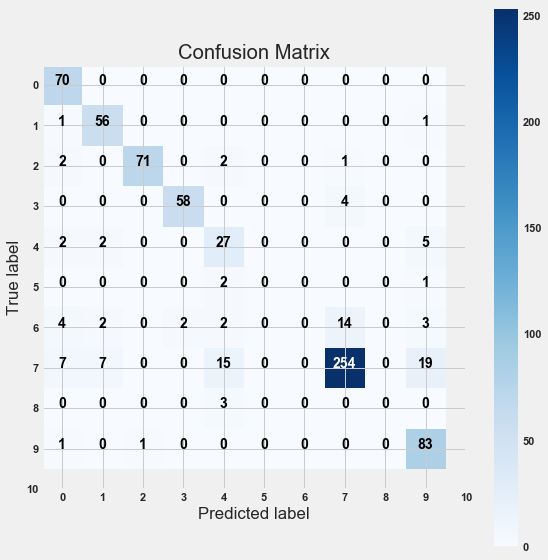

In [103]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, class_names, normalize=False, title = "Confusion Matrix")

**Learning Curve**

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample.

In [104]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel('Training examples')
    plt.ylabel('score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1, color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross Validation score')
    
    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the SVC classifier:

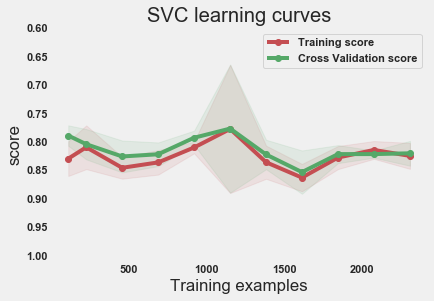

In [105]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

#### Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the Class_Fit class, adjust the model on the training data and see how the predictions compare to the real values

In [124]:
lr = Class_Fit(clf=linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X_train, Y_train)
lr.grid_predict(X_test, Y_test)

Precision:85.73%


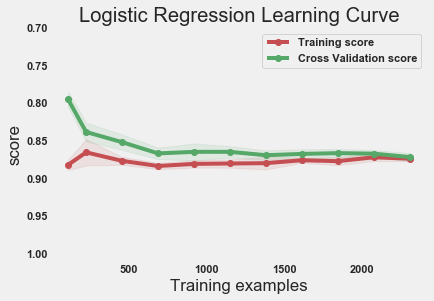

In [125]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression Learning Curve", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### K-Nearest Neighbour


In [126]:
knn = Class_Fit(clf=neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold=5)
knn.grid_fit(X_train, Y_train)
knn.grid_predict(X_test, Y_test)

Precision:78.81%


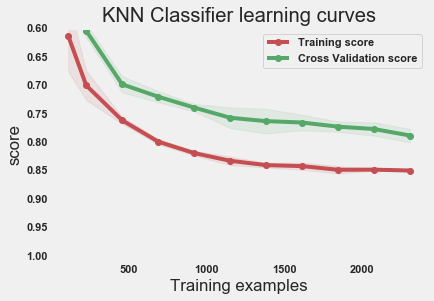

In [128]:
g = plot_learning_curve(knn.grid.best_estimator_, "KNN Classifier learning curves", X_train, Y_train,
                       ylim=[1.01,0.6], cv=5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Decision Tree

In [131]:
tr = Class_Fit(clf=tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold=5)
tr.grid_fit(X_train, Y_train)
tr.grid_predict(X_test, Y_test)

Precision:85.32%


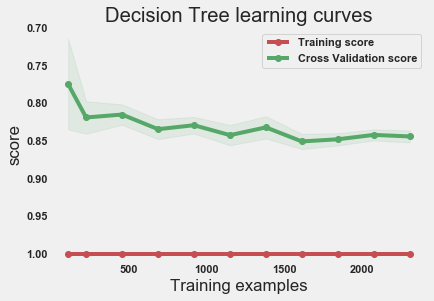

In [132]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision Tree learning curves", X_train, Y_train,
                       ylim=[1.01,0.7], cv=5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Random Forest

In [134]:
rf = Class_Fit(clf=ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold=5)
rf.grid_fit(X_train, Y_train)
rf.grid_predict(X_test, Y_test)

Precision:89.34%


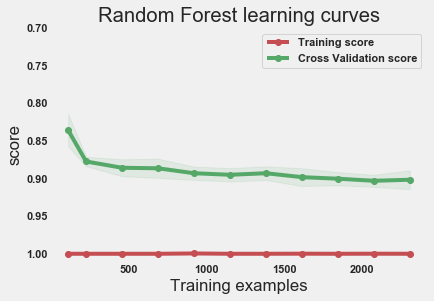

In [135]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                       ylim=[1.01,0.7], cv=5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####  AdaBoost Classifier

In [139]:
ada = Class_Fit(clf=ensemble.AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold=5)
ada.grid_fit(X_train, Y_train)
ada.grid_predict(X_test, Y_test)

Precision:51.80%


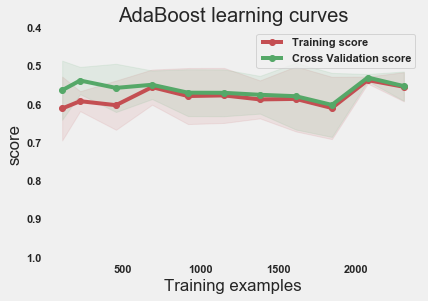

In [141]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Gradient Boosting Classifier

In [142]:
gb = Class_Fit(clf=ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold=5)
gb.grid_fit(X_train, Y_train)
gb.grid_predict(X_test, Y_test)

Precision:90.44%


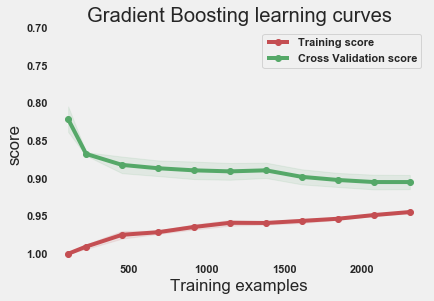

In [144]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                       ylim=[1.01,0.7], cv=5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Let's Vote

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the VotingClassifier method of the sklearn package. As a first step, I adjust the parameters of the various classifiers using the best parameters previously found:

In [146]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [149]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best), ('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

In [150]:
votingC = votingC.fit(X_train, Y_train)

In [151]:
votingC

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min...ki',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

Finally, we can create a prediction for this model:

In [153]:
predictions = votingC.predict(X_test)
print('Precision:{:.2f} %'.format(100*metrics.accuracy_score(Y_test, predictions)))

Precision:90.86 %


### Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [154]:
basket_price = set_test.copy(deep=True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables count and sum to obtain an equivalence with the training set:

In [156]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket_Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,5.634767,20.017905,17.732401,24.271627,32.343299
1,12349,5,1757.55,1757.55,1757.55,8787.75,20.389178,26.506216,30.145373,10.713778,12.245455
2,12352,5,311.73,311.73,311.73,1558.65,17.290604,34.420813,32.335675,7.217785,8.735123
3,12356,5,58.35,58.35,58.35,291.75,0.000000,0.000000,100.000000,0.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,25.189000,18.475531,13.300643,28.350089,14.684737


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [157]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables count , min , max and sum ). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the kmeans method used in section 4. Thepredict method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [158]:
Y = kmeans.predict(scaled_test_matrix)

In [159]:
Y

array([6, 4, 7, ..., 1, 6, 7])

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [161]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [163]:
X[:5]

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
0,759.57,5.634767,20.017905,17.732401,24.271627,32.343299
1,1757.55,20.389178,26.506216,30.145373,10.713778,12.245455
2,311.73,17.290604,34.420813,32.335675,7.217785,8.735123
3,58.35,0.000000,0.000000,100.000000,0.000000,0.000000
4,6207.67,25.189000,18.475531,13.300643,28.350089,14.684737


It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [162]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision:70.99%
______________________________ 
Logostic Regression
Precision:71.93%
______________________________ 
k-Nearest Neighbors
Precision:67.19%
______________________________ 
Decision Tree
Precision:71.34%
______________________________ 
Random Forest
Precision:74.64%
______________________________ 
Gradient Boosting
Precision:75.19%


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because this leads to a slight improvement in predictions:

In [164]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 75.62 % 
